In [516]:
from systemclass import SNAIL,SNAILC,SNAIL_sweep,SNAILC_sweep,Cavity
import numpy as np
from qutip import *
import matplotlib.pyplot as plt

In [517]:
## import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from cosmatrix import cosm,expm_pade
expm = expm_pade
from autograd.extend import primitive, defvjp
from qutip import *
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def SNAIL_H(phi_ex,beta,N,Ej,Ec):
    phi_ex = 2*np.pi*phi_ex
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp

    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    c3 = (N**2-1)/N**2*np.sin(phi_min/N)
    g3 = Ej*phi_zpf**3*c3/3/2
    c4 = -beta*np.cos(phi_min-phi_ex) -1/N**3*np.cos(phi_min/N)

    g4 = Ej*phi_zpf**4*c4/4/3/2
    Hs = omega_s * np.matmul(sd,s)+(
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    energy,U = np.linalg.eigh(Hs)
    for i in range(U.shape[1]):
        if U[i, i] < 0:
            U[:, i] *= -1
    U_dag = np.conjugate(U.transpose())
    
    Hs = Hs
    
    return Hs-energy[0]*np.identity(sdim),-1j*(s-sd),phi_zpf,c2

In [518]:
def sort(energies,U,H):
    diagonal_elements = np.diag(H)

    # Find the index of the closest diagonal element for each eigenvalue
    closest_indices = np.argmin(abs(energies[:, np.newaxis] - diagonal_elements), axis=1)

    # Sort energies and U according to the indices of closest diagonal elements
    sorted_energies = energies[np.argsort(closest_indices)]
    U = U[:, np.argsort(closest_indices)]
    return sorted_energies,U

def sort_energy(energies,H):
    diagonal_elements = np.diag(H)

    # Find the index of the closest diagonal element for each eigenvalue
    closest_indices = np.argmin(abs(energies[:, np.newaxis] - diagonal_elements), axis=1)

    # Sort energies and U according to the indices of closest diagonal elements
    sorted_energies = energies[np.argsort(closest_indices)]
    return sorted_energies
def floquet_spec3(phi_ex):
    EJ = 90*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 100
    flux = 0.48
    N = 3
    dims = 10
    H0,v,phi_zpf,c2 = SNAIL_H(phi_ex,beta,N,EJ,EC)
#     omega_c1 = 7*2*np.pi
#     g_int1 = 0.15*2*np.pi
    dimc1 = 10
    trunc1 = dims * dimc1
    cavity1 = Cavity(omega_c1,g_int1,dimc1)
    
    snail_back = SNAIL(EJ,EC,beta,ng,ncut,phi_ex,N,dims)
    snailc =  SNAILC(snail_back, cavity1, trunc1)
    snailc.parameters()
    Hs , charge_op = snailc.dressed_H, snailc.dressed_charge
    a=np.abs(np.sort(np.diag(Hs)))
    omegas = snail_back.omegas
    s = annihilation(dims)
    sd = creation(dims)
    c = annihilation(dimc1)
    cd = creation(dimc1)
    Hs,charge_op = H0,v
    energies,U=np.linalg.eig(H0)
    energies,U = sort(energies,U,Hs)
    Ud = U.transpose().conjugate()
    omega_s = energies[1]
    charge_op = charge_op/2/phi_zpf
    
    Hc1, Vc1 = cavity1.hamiltonian()
    Ic1 = np.identity(dimc1)
    Is = np.identity(dims)
    Hs = np.kron(Hs,Ic1)
    Hc1 = np.kron(Is,Hc1)
    H_int1 = cavity1.g_int * np.kron(charge_op,Vc1) * 2 * ((2 * snail_back.EC / snail_back.EJ) ** 0.25)   
    Hs = Hs + Hc1 + H_int1 
    energies,U=np.linalg.eig(Hs)
    energies,U = sort(energies,U,Hs)
    energy1 = energies - energies[0]*np.ones(len(energies))
    energy2 = energies - energies[0]*np.ones(len(energies))

    detuning = omegas
    indexs1 = np.argmin(np.abs(energy1 - detuning * np.ones(len(energy1))))
    indexs2 = np.argmin(np.abs(energy1 - (2*detuning + snail_back.anh ) * np.ones(len(energy1))))
    indexc1 = np.argmin(np.abs(energy2 - omega_c1 * np.ones(len(energy1))))
    energys1 = energy1[indexs1]
    energyc1 = energy2[indexc1] 
    
    indexc2 = np.argmin(np.abs(energy2 - 2 * omega_c1 * np.ones(len(energy1))))
    indexsc = np.argmin(np.abs(energy1 - (detuning + omega_c1) * np.ones(len(energy1))))
    indexsc2 = np.argmin(np.abs(energy1 - (detuning + 2*omega_c1) * np.ones(len(energy1))))
    energysc = energy1[indexsc]
    energyc2 = energy2[indexc2]
    energysc2 = energy1[indexsc2]
    starkshift = energysc  - energyc1 - energys1
    selfkerr = energyc2 - 2*energyc1
    print(energyc2/2/np.pi,energyc1/2/np.pi)
#     print(selfkerr/2/np.pi)
    starkshift2 = energysc2  - 2*energyc1 - energys1 - 2*starkshift - 2*selfkerr
    return energyc1/2/np.pi, starkshift/2/np.pi, selfkerr/2/np.pi

In [515]:
floquet_spec3(0)

0.15
(3.991417732771492+0j) (1.9957088666124043+0j)


((1.9957088666124043+0j),
 (-1.0626892244672438e-05+0j),
 (-4.5331640134380204e-10+0j))

In [503]:
omega_c1 = 4*2*np.pi
g_int1 = 0.15*2*np.pi

In [504]:
from joblib import Parallel, delayed
fluxs = np.linspace(0., 0.5, 200)
result = Parallel(n_jobs=-1)(delayed(floquet_spec3)(flux) for flux in fluxs)
result = np.array(result)

In [505]:
def app(phi_ex):
    EJ = 90*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 10
    snail = SNAIL(EJ,EC,beta,ng,ncut,phi_ex,N,dims)
    H0,v,phi_zpf,c2 = SNAIL_H(phi_ex,beta,N,EJ,EC)
    g3 = snail.g3
    g4 = snail.g4
    omega_s = H0[1][1]-H0[0,0]
    anh = H0[2][2]-H0[1,1] - (omega_s )
    g = (g_int1 * 2 * ((2 * snail.EC/ snail.EJ) ** 0.25)/2/phi_zpf)
    energyc11 = omega_c1 + g**2/(omega_c1-omega_s) - g**2/(omega_c1+omega_s)
    omegap = 1/((8*omega_c1**2-3*omega_s**2)/(omega_s*(2*omega_c1-omega_s)*(omega_s+2*omega_c1)))
    selfkerr1 =(12*g4 - 72*g3**2/omega_s*(omega_s/omegap/2))*(g/(omega_s-omega_c1))**4
    omegap = 1/((omega_c1**2-6*omega_s**2)/(omega_s*(omega_c1-2*omega_s)*(2*omega_s+omega_c1)))
    starkshift11 = 24*(g4-3*g3**2/omega_s*omega_s/omegap)*(g/(omega_s-omega_c1))**2
    return energyc11/2/np.pi,  starkshift11/2/np.pi,  selfkerr1/2/np.pi,

In [506]:
app(0.37)

(array([1.99552087+0.j]),
 array([-3.55918047e-05+0.j]),
 array([-4.00529781e-08+0.j]))

In [507]:
result_app = Parallel(n_jobs=-1)(delayed(app)(flux) for flux in fluxs)
result_app = np.array(result_app)

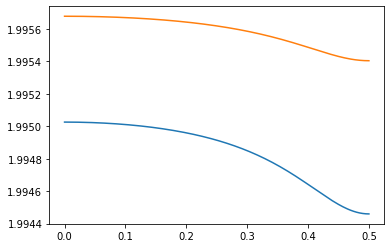

In [508]:
plt.plot(fluxs,result[:,0])
plt.plot(fluxs,result_app[:,0])

(-2e-05, 2e-05)

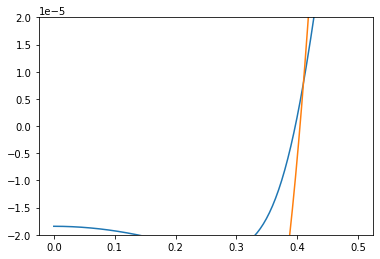

In [509]:
plt.plot(fluxs,result[:,1])
plt.plot(fluxs,result_app[:,1])
plt.ylim(-2e-5,2e-5)

(-1e-08, 1e-08)

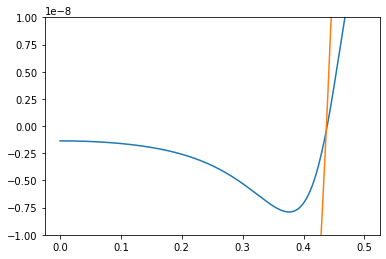

0.15
(3.9899801163807713+0j) (1.9949900591766239+0j)
0.15
(3.98927311789781+0j) (1.9946365624086535+0j)
0.15
(3.990010705858854+0j) (1.995005353777019+0j)
0.15
(3.989752447865314+0j) (1.994876226232477+0j)
0.15
(3.98919544433071+0j) (1.9945977246845517+0j)
0.15
(3.9900513587443633+0j) (1.9950256800525117+0j)
0.15
(3.989957943187774+0j) (1.994978972687225+0j)
0.15
(3.9895821584933517+0j) (1.9947910826092279+0j)
0.15
(3.990049139836378+0j) (1.9950245706071545+0j)
0.15
(3.9899247334792887+0j) (1.9949623680034854+0j)
0.15
(3.9897387017882626+0j) (1.9948693532832704+0j)
0.15
(3.9889983053766556+0j) (1.9944991491369195+0j)
0.15
(3.990014296876585+0j) (1.9950071492703108+0j)
0.15
(3.9897591440712383+0j) (1.9948795742920755+0j)
0.15
(3.9890600864957606+0j) (1.9945300423248356+0j)
0.15
(3.9900069282325+0j) (1.9950034649803319+0j)
0.15
(3.989694510024939+0j) (1.9948472576888945+0j)
0.15
(3.9890076903432785+0j) (1.9945038420721666+0j)
0.15
(3.9900498806064157+0j) (1.9950249409892495+0j)
0.15
(3.9

0.15
(3.9900501950898453+0j) (1.995025098229818+0j)
0.15
(3.989935382139641+0j) (1.994967692277726+0j)
0.15
(3.9898200275369486+0j) (1.9949100156382613+0j)
0.15
(3.9892859848562017+0j) (1.994642995989392+0j)
0.15
(3.990046631331341+0j) (1.9950233163644153+0j)
0.15
(3.989931900389812+0j) (1.9949659514209628+0j)
0.15
(3.989489979300569+0j) (1.9947449934355732+0j)
0.15
(3.9899921804419916+0j) (1.9949960911512554+0j)
0.15
(3.9897387017882706+0j) (1.9948693532832658+0j)
0.15
(3.989017473291691+0j) (1.9945087339964087+0j)
0.15
(3.9900513033958784+0j) (1.9950256523784953+0j)
0.15
(3.989928351164049+0j) (1.9949641768267043+0j)
0.15
(3.9897591440712423+0j) (1.9948795742920784+0j)
0.15
(3.9890276293720435+0j) (1.9945138124817767+0j)
0.15
(3.990034483985455+0j) (1.9950172427401058+0j)
0.15
(3.9898309636997284+0j) (1.9949154836522853+0j)
0.15
(3.989260207084576+0j) (1.9946301068859515+0j)
0.15
(3.9900501950899434+0j) (1.9950250982297983+0j)
0.15
(3.98994865329288+0j) (1.994974327786295+0j)
0.15
(3

0.15
(3.9899966424104014+0j) (1.9949983221151826+0j)
0.15
(3.98931154339365+0j) (1.9946557754207466+0j)
0.15
(3.990048713378946+0j) (1.9950243573800617+0j)
0.15
(3.9899387973750993+0j) (1.9949693998777522+0j)
0.15
(3.9895008142112274+0j) (1.9947504108518872+0j)
0.15
(3.9889196887603258+0j) (1.9944598361699069+0j)
0.15
(3.9900125244658864+0j) (1.9950062630726337+0j)
0.15
(3.9897316484611234+0j) (1.9948658266655306+0j)
0.15
(3.989144297465137+0j) (1.9945721502639573+0j)
0.15
(3.989985100908467+0j) (1.9949925514171214+0j)
0.15
(3.9893492989169226+0j) (1.9946746533370598+0j)
0.15
(3.9899775427393327+0j) (1.9949887723680457+0j)
0.15
(3.9895627149090824+0j) (1.994781360921024+0j)
0.15
(3.9889278546313895+0j) (1.9944639196689011+0j)
0.15
(3.9900510819384203+0j) (1.995025541650649+0j)
0.15
(3.989966689707192+0j) (1.9949833459040283+0j)
0.15
(3.98960101131095+0j) (1.9948005089116507+0j)
0.15
(3.9889314119824304+0j) (1.9944656985836842+0j)
0.15
(3.990020933162578+0j) (1.995010467384946+0j)
0.15


0.15
(3.9900193412654184+0j) (1.9950096714431171+0j)
0.15
(3.9896706686250405+0j) (1.9948353371422582+0j)
0.15
(3.9889355884487174+0j) (1.9944677870930039+0j)
0.15
(3.9900069282324693+0j) (1.995003464980357+0j)
0.15
(3.989717172591096+0j) (1.9948585888248163+0j)
0.15
(3.98899830537665+0j) (1.9944991491369193+0j)
0.15
(3.9900387433630233+0j) (1.9950193724116834+0j)
0.15
(3.989870985464906+0j) (1.9949354942956794+0j)
0.15
(3.989311543393603+0j) (1.9946557754207535+0j)
0.15
(3.9900504724052435+0j) (1.995025236886424+0j)
0.15
(3.989921046330501+0j) (1.9949605244487312+0j)
0.15
(3.989702192981856+0j) (1.9948510991175805+0j)
0.15
(3.989017473291668+0j) (1.9945087339964127+0j)
0.15
(3.9900491398364006+0j) (1.995024570607127+0j)
0.15
(3.9899283511640617+0j) (1.9949641768267288+0j)
0.15
(3.989511502163109+0j) (1.9947557547860895+0j)
0.15
(3.990032110231176+0j) (1.9950160558727354+0j)
0.15
(3.989830963699727+0j) (1.994915483652257+0j)
0.15
(3.9891825520148925+0j) (1.99459127830845+0j)
0.15
(3.99

In [511]:
plt.plot(fluxs,result[:,2])
plt.plot(fluxs,(result_app[:,2]))
plt.ylim(-1e-8,1e-8) 